## node2vec: Scalable Feature Learning for Networks

In [1]:
'''
Reference implementation of node2vec. 
Author: Aditya Grover
For more details, refer to the paper:
node2vec: Scalable Feature Learning for Networks
Aditya Grover and Jure Leskovec 
Knowledge Discovery and Data Mining (KDD), 2016
'''
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
#import node2vec
from gensim.models import Word2Vec
import random

### 1. load data

1) initialize

2）read graph
using networkx to load edgelist

3）in-out

input '../graph/karate.edgelist'

output'../emb/karate.emb'

In [2]:
def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    # load
    parser = argparse.ArgumentParser(description="Run node2vec.")
    # input 
    parser.add_argument('--input', nargs='?', default='../graph/karate.edgelist',
                        help='Input graph path')
    # out
    parser.add_argument('--output', nargs='?', default='../emb/karate.emb',
                        help='Embeddings path')
    # dimension
    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')
    # length of walks
    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')
    # num of walks
    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')
    # windowsize
    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')
    # epoch
    parser.add_argument('--iter', default=1, type=int,
                        help='Number of epochs in SGD')
    # parallel workers
    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')
    # p
    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')
    # q
    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')
    # weighted
    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)
    # directed
    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)
    
    return parser.parse_args(args=[])
    # return parser.parse_known_args()

In [3]:
def read_graph():
    '''
    Reads the input network in networkx.
    '''
    # weighted
    if args.weighted:
        G = nx.read_edgelist(args.input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
    # unweighted
    else:
        G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1
    # to undirected
    if not args.directed:
        G = G.to_undirected()

    return G

In [4]:
# set parameters according to parser
args = parse_args()
# read graph
nx_G = read_graph()
print (len(nx_G))

34


In [5]:
args

Namespace(dimensions=128, directed=False, input='../graph/karate.edgelist', iter=1, num_walks=10, output='../emb/karate.emb', p=1, q=1, undirected=True, unweighted=True, walk_length=80, weighted=False, window_size=10, workers=8)

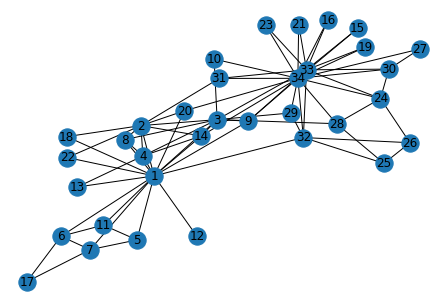

In [6]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

### 2. set up alias table of nodes and edges

In [7]:
class Graph():
    # initialize
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q
    
    
    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        # O(1) alias sampling
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            # align with alias table
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                # start scenario
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                # common scenario
                else:
                    # prev is node t in paper
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print ('Walk iteration:')
        for walk_iter in range(num_walks):
            print (str(walk_iter+1), '/', str(num_walks))
            # shuffle
            random.shuffle(nodes)
            for node in nodes:
                # node2vec_walk is a biased random walk
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        # section 3.2.2
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        
        # normarlize 
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        # node alias sampling and normalize
        # node sampling is used for the start scienario (have no prevs)
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)
            if node == 2:
                print (unnormalized_probs)
                print (norm_const)
                print (normalized_probs)
                print (alias_nodes[node])

        alias_edges = {}
        triads = {}
        
        # edge alias sampling and normalize
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
        
        print ('edges alias')
        print (alias_edges[(2, 3)])
        print (alias_edges[(3, 2)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return

In [8]:
def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    # q corrsespond to Prob
    q = np.zeros(K)
    # J Alias
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    
    # seperate prob into 2 groups, one for larger than one and one for smaller than 1
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)
    
    # greed algo to setup
    # pseudo code step 3
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        # update prob
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

In [9]:
def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    # select self
    if np.random.rand() < q[kk]:
        return kk
    # select alias
    else:
        return J[kk]

In [10]:
# initialize 
G = Graph(nx_G, args.directed, args.p, args.q)

# generate alias table
G.preprocess_transition_probs()
print ('nodes and edges alias sampling')

[1, 1, 1, 1, 1, 1, 1, 1, 1]
9
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))
edges alias
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))
nodes and edges alias sampling


### 3.Use Biased Random Walk to Generate a Walk Senquence

In [11]:
def simulate_walks(self, num_walks, walk_length):
    '''
    Repeatedly simulate random walks from each node.
    '''
    G = self.G
    walks = []
    nodes = list(G.nodes())
    print ('Walk iteration:')
    for walk_iter in range(num_walks):
        print (str(walk_iter+1), '/', str(num_walks))
        # shuffle
        random.shuffle(nodes)
        for node in nodes:
            # node2vec_walk is a biased random walk
            walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

    return walks

In [12]:
def node2vec_walk(self, walk_length, start_node):
    '''
    Simulate a random walk starting from start node.
    '''
    G = self.G
    # O(1) alias sampling 
    alias_nodes = self.alias_nodes
    alias_edges = self.alias_edges

    walk = [start_node]
    
    while len(walk) < walk_length:
        cur = walk[-1]
        # 对邻居节点排序，目的是和alias table计算时的顺序对应起来
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs) > 0:
            # start  
            if len(walk) == 1:
                # alias_nodes[cur][0] -- alias table
                # alias_nodes[cur][1] -- probability table
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            # len(senq) larger than 1
            else:
                # prev is node t in paper
                prev = walk[-2]
                next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                    alias_edges[(prev, cur)][1])]
                walk.append(next)
        else:
            break

    return walk

In [13]:
# biased random walks sequence
walks = G.simulate_walks(args.num_walks, args.walk_length)
print (len(walks[0]))

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
80


### 4. Use Gensim.Word2Vec to Train Model

In [15]:
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    # walks = [map(str, walk) for walk in walks]
    walk_lol = []
    for walk in walks:
        tmp = []
        for node in walk:
            tmp.append(str(node))
        walk_lol.append(tmp)
    # Use Gensim.Word2Vec
    model = Word2Vec(walk_lol, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers,
                     iter=args.iter)
    # model.save_word2vec_format(args.output)
    # save embedding
    model.wv.save_word2vec_format(args.output)

    return model

In [16]:
model = learn_embeddings(walks)
print ('finished')

finished


### 5. Result Visualize

In [17]:
model['17']

array([ 1.82717144e-02, -1.78798556e-01,  5.52448891e-02,  6.94971299e-03,
       -2.05650657e-01, -5.56412786e-02,  2.48747408e-01,  4.44451906e-02,
        8.31546262e-02, -7.39877112e-03,  1.07373729e-01, -1.80477694e-01,
       -1.26473874e-01,  1.12795588e-02,  1.16202831e-01, -6.92656785e-02,
        2.42864043e-02, -8.16724524e-02, -4.77876700e-02,  6.72359392e-02,
       -5.10266386e-02, -6.61241859e-02,  8.72129127e-02,  2.34830722e-01,
        6.56319782e-02,  3.58124599e-02,  1.85662314e-01,  8.57771337e-02,
       -9.11579654e-02, -7.43679628e-02,  4.68363017e-02,  6.17256425e-02,
        7.88122565e-02,  4.93080206e-02, -1.05201220e-02,  2.58395020e-02,
       -2.02500403e-01,  6.84054643e-02,  8.74758977e-03, -4.48581204e-03,
       -6.51045218e-02, -1.77287936e-01, -5.63082248e-02,  1.27615690e-01,
       -1.62746191e-01, -3.69068980e-02, -5.75895943e-02, -1.62056357e-01,
       -9.55627859e-02,  6.75422251e-02, -7.21617192e-02, -1.99187323e-02,
       -8.36243704e-02,  

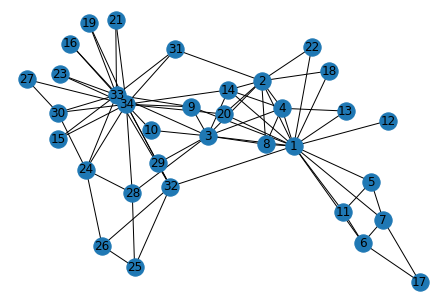

In [18]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

In [19]:
# # similar 1
# print(model.similarity('17', '6'))
# print(model.similarity('7', '6'))
# print(model.similarity('26', '12'))

# # similar 2
# print(model.similarity('34', '33'))
# print(model.similarity('34', '9'))
# print(model.similarity('34', '31'))

# # not similar
# print(model.similarity('17', '25'))
# print(model.similarity('7', '25'))

# # most similar nodes group
print (model.wv.most_similar('34'))

[('33', 0.9990593791007996), ('24', 0.9988579750061035), ('30', 0.9986412525177002), ('25', 0.998197615146637), ('32', 0.9977360963821411), ('26', 0.9974973201751709), ('28', 0.9973618984222412), ('15', 0.9973217248916626), ('19', 0.9967416524887085), ('23', 0.9964841604232788)]


In [20]:
from scipy import spatial
def cos_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

# # similar 1
print (cos_similarity(model['17'], model['6']))
print (cos_similarity(model['7'], model['6']))
print (cos_similarity(model['7'], model['5']))


# # similar 2
# print (cos_similarity(model['34'], model['33']))
# print (cos_similarity(model['34'], model['9']))
# print (cos_similarity(model['34'], model['31']))

# # not similar
# print (cos_similarity(model['17'], model['25']))
# print (cos_similarity(model['7'], model['25']))

0.9993247389793396
0.996070921421051
0.9871399402618408


In [21]:
# k-means clustering
from sklearn import  cluster
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import pandas as pd
embedding_node=[]
for i in range(1,35):
    j=str(i)
    embedding_node.append(model[j])
embedding_node=np.matrix(embedding_node).reshape((34,-1))
y_pred = cluster.KMeans(n_clusters=4, random_state=9).fit_predict(embedding_node) # 调用 test_RandomForestClassifier
y_pred

array([1, 1, 2, 2, 1, 3, 3, 2, 2, 0, 3, 2, 2, 2, 0, 0, 3, 1, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

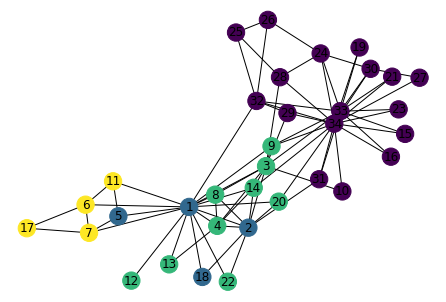

In [22]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True,nodelist=sorted(nx_G.nodes()),node_color=list(y_pred))
plt.show()